In [1]:
# Package Dependencies
from pandas import read_csv
from matplotlib import pyplot
from random import shuffle
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import platform
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sys import platform
import pydot
import graphviz
from keras.utils import plot_model
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
def read_and_process_data(directory_path):
    data_frames = []
    columns_to_extract = ['radius_X', 'radius_Y', 'radius_Z', 'radius_Ox', 'radius_Oy', 'radius_Oz', 'Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

    # Assuming each cycle has exactly 356 data points
    total_data_points = 356

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory_path, file_name)
            participant = int(os.path.basename(file_path).split('_')[0])
            cycle_id = os.path.basename(file_path).split('_')[1].split('.')[0]  # Extract cycle_id
            intensity = cycle_id[:4]  # Extract the first four characters of cycle_id as intensity

            # Read data from CSV and select only the desired columns
            df = pd.read_csv(file_path, usecols=columns_to_extract)

            # Add participant ID, cycle_id, and participant_cycle_id as features
            df['Participant'] = participant
            df['Cycle_ID'] = cycle_id
            df['Participant_Cycle_ID'] = f"{participant}_{cycle_id}"

            # Add normalized_cycle_position
            df['Normalized_Cycle_Position'] = df.index / (total_data_points - 1)
            df['Intensity'] = intensity  # this is either "HIIT" or "MICT"

            data_frames.append(df)

    # Concatenate all data frames
    processed_data = pd.concat(data_frames, ignore_index=True)

    # Merge with participant weights
    weights_df = pd.read_csv("Participant_Weights_Median_Imputed.csv")
    weights_df['Weight'] = weights_df['Weight'].astype(float)
    weights_df['Wingspan'] = weights_df['Wingspan'].astype(float)
    processed_data = pd.merge(processed_data, weights_df, left_on='Participant', right_on='Participant')

    return processed_data

 # Set up paths
data_directory = "Processed Data for ML"

# Read and process data
data = read_and_process_data(data_directory)
data['Intensity'] = data['Intensity'].map({'HIIT': 0.9, 'MICT': 0.5})
data = data.drop(columns=['Cycle_ID', 'Participant_Cycle_ID', 'Normalized_Cycle_Position'])
data = data[data.columns[-3:].tolist() + data.columns[:-3].tolist()]
data.head()

,Intensity,Weight,Wingspan,radius_X,radius_Y,radius_Z,radius_Ox,radius_Oy,radius_Oz,Fx,Fy,Fz,Tx,Ty,Tz,Participant
0,0.9,160.0,172.72,0.165734,3.447147,-0.586449,-33.584860,22.706178,23.796136,-51.709616,-46.127911,-17.304707,2.308679,-2.609106,0.160727,1
1,0.9,160.0,172.72,-0.558583,5.960017,-0.982137,-35.125067,23.634133,25.040792,-52.574803,-46.360920,-17.348756,2.313128,-2.647273,0.163128,1
2,0.9,160.0,172.72,-0.745809,7.628433,-1.253003,-32.797160,21.771117,23.734505,-53.439989,-46.593930,-17.392805,2.317576,-2.685440,0.165529,1
3,0.9,160.0,172.72,-0.873545,9.056784,-1.483014,-32.127317,20.874672,23.749559,-54.305175,-46.826939,-17.436854,2.322025,-2.723607,0.167930,1
4,0.9,160.0,172.72,-1.466533,9.160957,-1.469740,-33.084583,20.902988,25.077196,-55.262267,-47.146885,-17.449009,2.328763,-2.764219,0.170598,1


In [3]:
# Get unique participant IDs
participants = data['Participant'].unique()

# Shuffle participant IDs
np.random.shuffle(participants)

# Split participant IDs into train, validation, and test
train_participants = participants[:14]
validation_participants = participants[14:17]
test_participants = participants[17:]

# Create train, validation, and test sets
train_data = data[data['Participant'].isin(train_participants)].drop(columns='Participant')
validation_data = data[data['Participant'].isin(validation_participants)].drop(columns='Participant')
test_data = data[data['Participant'].isin(test_participants)].drop(columns='Participant')

print(train_data.shape, validation_data.shape, test_data.shape)
train_data2 = np.empty([int(len(train_data)/356),356,len(train_data.columns)])
for i in range(int(len(train_data)/356)):
    train_data2[i,:,:] = train_data[356*i:i*356+356]
np.random.shuffle(train_data2)
print(train_data2.shape)

test_data2 = np.empty([int(len(test_data)/356),356,len(test_data.columns)])
for i in range(int(len(test_data)/356)):
    test_data2[i,:,:] = test_data[356*i:i*356+356]
np.random.shuffle(test_data2)
print(test_data2.shape)

val_data2 = np.empty([int(len(validation_data)/356),356,len(validation_data.columns)])
for i in range(int(len(validation_data)/356)):
    val_data2[i,:,:] = validation_data[356*i:i*356+356]
np.random.shuffle(val_data2)
print(val_data2.shape)

(59452, 15) (12816, 15) (12816, 15)
(167, 356, 15)
(36, 356, 15)
(36, 356, 15)


In [4]:
# Initialize new StandardScaler instances
train_scaler_X = StandardScaler()
train_scaler_y = StandardScaler()
val_scaler_X = StandardScaler()
val_scaler_y = StandardScaler()
test_scaler_X = StandardScaler()
test_scaler_y = StandardScaler()

# Separate X and y
train_X = train_data2[:, :, :-6]
train_y = train_data2[:, :, -6:]
val_X = val_data2[:, :, :-6]
val_y = val_data2[:, :, -6:]
test_X = test_data2[:, :, :-6]
test_y = test_data2[:, :, -6:]

#Fit the scalers to the data and transform it
train_X = train_scaler_X.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_y = train_scaler_y.fit_transform(train_y.reshape(-1, train_y.shape[-1])).reshape(train_y.shape)
val_X = val_scaler_X.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_y = val_scaler_y.fit_transform(val_y.reshape(-1, val_y.shape[-1])).reshape(val_y.shape)
test_X = test_scaler_X.fit_transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
test_y = test_scaler_y.fit_transform(test_y.reshape(-1, test_y.shape[-1])).reshape(test_y.shape)

# Confirm these are the correct shapes
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(val_X.shape)
print(val_y.shape)

print(train_X[0].min, train_X[0].max)

(167, 356, 9)
(167, 356, 6)
(36, 356, 9)
(36, 356, 6)
(36, 356, 9)
(36, 356, 6)
<built-in method min of numpy.ndarray object at 0x00000220851759F0> <built-in method max of numpy.ndarray object at 0x00000220851769F0>


In [5]:
def get_lstm_model(input_shape=9, output_shape=6, num_nodes=200, dropout=0.45, regularization=0.00001, num_layers=4):
    visible1 = tf.keras.layers.Input(shape=(None, input_shape))
    x = visible1
    for _ in range(num_layers):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_nodes, return_sequences=True, 
                                                               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regularization, l2=regularization), 
                                                               recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=regularization, l2=regularization)))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.SpatialDropout1D(dropout)(x)
    output = tf.keras.layers.Dense(output_shape)(x)

    lstm_model = tf.keras.Model(inputs=visible1, outputs=output)
    return lstm_model

In [6]:
def get_lstm_model(num_nodes, num_layers):
    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=(None, 9))  # Adjusted for one less feature

    # Assuming input_layer is of shape (batch_size, time_steps, features)
    intensity_feature = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, 0], -1))(input_layer)
    #intensity_feature = tf.keras.layers.Normalization()(intensity_feature)
    #intensity_feature = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50))(intensity_feature)

    weight_feature = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, 1], -1))(input_layer)
    #weight_feature = tf.keras.layers.Normalization()(weight_feature)
    #weight_feature = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50))(weight_feature)

    wingspan_feature = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:, :, 2], -1))(input_layer)
    #wingspan_feature = tf.keras.layers.Normalization()(wingspan_feature)
    #wingspan_feature = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(50))(wingspan_feature)

    # Extract the other features and standardize them
    other_features = tf.keras.layers.Lambda(lambda x: x[:, :, 3:])(input_layer)  # Adjusted for three less features
    #other_features = tf.keras.layers.Normalization()(other_features)

    # Add the LSTM layers with dropout
    for _ in range(num_layers):
        other_features = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                num_nodes, 
                return_sequences=True, 
                dropout=0.3,
                kernel_regularizer=tf.keras.regularizers.l1_l2(0.001),  # Regularization on the weights (kernel)
                recurrent_regularizer=tf.keras.regularizers.l1_l2(0.001),  # Regularization on the recurrent weights
                bias_regularizer=tf.keras.regularizers.l1_l2(0.001)  # Regularization on the bias
            )
        )(other_features)
        # Batch normalization layer
        other_features = tf.keras.layers.BatchNormalization()(other_features)

    # Concatenate the Dense-processed intensity, weight, wingspan, and the other features
    data = tf.keras.layers.Concatenate(axis=-1)([intensity_feature, weight_feature, wingspan_feature, other_features])
    # Add an attention layer
    #data = tf.keras.layers.Attention()([data, data])

    # Add a Dense layer
    data = tf.keras.layers.Dense(128, activation='relu')(data)

    # Add a Dropout layer
    data = tf.keras.layers.Dropout(0.5)(data)

    # Add the output layer
    output_layer = tf.keras.layers.Dense(6)(data)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [7]:
model = get_lstm_model(num_nodes=300, num_layers=2)
print(model.summary())

class MedianPercentageError(tf.keras.metrics.Metric):
    def __init__(self, name='median_percentage_error', **kwargs):
        super(MedianPercentageError, self).__init__(name=name, **kwargs)
        self.median_percentage_errors = self.add_weight(name='mpes', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        percentage_error = 100 * tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, 1e7))
        percentage_error_sorted = tf.sort(percentage_error, axis=1)
        median_index = tf.shape(percentage_error)[1] // 2
        median_percentage_error = percentage_error_sorted[:, median_index, :]
        mean_median_percentage_error = tf.reduce_mean(median_percentage_error, axis=-1)
        mean_of_means = tf.reduce_mean(mean_median_percentage_error)
        self.median_percentage_errors.assign(mean_of_means)

    def result(self):
        return self.median_percentage_errors

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.median_percentage_errors.assign(0.)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

checkpoint_path = f"Models\BidirectionalLSTM\cp_2layers_300nodes_{{epoch:02d}}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_mean_absolute_error',
    verbose=1, 
    save_weights_only=False,
    save_freq=600,
    save_best_only = False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=50,  # Number of epochs with no improvement after which training will be stopped
    min_delta = 0.01, # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

model_history = model.fit(x=train_X,y=train_y, epochs=1000, batch_size=int(16),
                            validation_data=(val_X,val_y),
                            callbacks=[cp_callback, early_stopping_callback], verbose = 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 9)]    0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, None, 6)      0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 600)    736800      ['lambda_3[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 600)   2400        ['bidirectional[0][0]']          
 alization)                                                                                   

INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_55.ckpt\assets


INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_55.ckpt\assets


11/11 [==============================] - 16s 2s/step - loss: 4.2620 - mean_absolute_error: 0.4420 - val_loss: 4.4031 - val_mean_absolute_error: 0.5732
Epoch 56/1000
11/11 [==============================] - 1s 126ms/step - loss: 4.1679 - mean_absolute_error: 0.4486 - val_loss: 4.3006 - val_mean_absolute_error: 0.5766
Epoch 57/1000
11/11 [==============================] - 1s 122ms/step - loss: 4.0875 - mean_absolute_error: 0.4553 - val_loss: 4.2103 - val_mean_absolute_error: 0.5725
Epoch 58/1000
11/11 [==============================] - 1s 108ms/step - loss: 3.9794 - mean_absolute_error: 0.4410 - val_loss: 4.0894 - val_mean_absolute_error: 0.5627
Epoch 59/1000
11/11 [==============================] - 1s 114ms/step - loss: 3.8614 - mean_absolute_error: 0.4357 - val_loss: 3.9335 - val_mean_absolute_error: 0.5383
Epoch 60/1000
11/11 [==============================] - 1s 117ms/step - loss: 3.7654 - mean_absolute_error: 0.4390 - val_loss: 3.8246 - val_mean_absolute_error: 0.5266
Epoch 61/1000


INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_110.ckpt\assets


INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_110.ckpt\assets


11/11 [==============================] - 16s 138ms/step - loss: 1.1690 - mean_absolute_error: 0.4132 - val_loss: 1.2624 - val_mean_absolute_error: 0.4920
Epoch 111/1000
11/11 [==============================] - 1s 116ms/step - loss: 1.1329 - mean_absolute_error: 0.4052 - val_loss: 1.2375 - val_mean_absolute_error: 0.4974
Epoch 112/1000
11/11 [==============================] - 1s 118ms/step - loss: 1.1069 - mean_absolute_error: 0.4060 - val_loss: 1.2083 - val_mean_absolute_error: 0.4968
Epoch 113/1000
11/11 [==============================] - 1s 125ms/step - loss: 1.0837 - mean_absolute_error: 0.4070 - val_loss: 1.1607 - val_mean_absolute_error: 0.4726
Epoch 114/1000
11/11 [==============================] - 1s 111ms/step - loss: 1.0679 - mean_absolute_error: 0.4102 - val_loss: 1.1606 - val_mean_absolute_error: 0.4781
Epoch 115/1000
11/11 [==============================] - 1s 115ms/step - loss: 1.0570 - mean_absolute_error: 0.4145 - val_loss: 1.1215 - val_mean_absolute_error: 0.4739
Epoch 

INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_164.ckpt\assets


INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_164.ckpt\assets


11/11 [==============================] - 16s 2s/step - loss: 0.6559 - mean_absolute_error: 0.3930 - val_loss: 0.7497 - val_mean_absolute_error: 0.4666
Epoch 165/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.6547 - mean_absolute_error: 0.3926 - val_loss: 0.7387 - val_mean_absolute_error: 0.4676
Epoch 166/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.6634 - mean_absolute_error: 0.3976 - val_loss: 0.7417 - val_mean_absolute_error: 0.4573
Epoch 167/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.6600 - mean_absolute_error: 0.3951 - val_loss: 0.7480 - val_mean_absolute_error: 0.4781
Epoch 168/1000
11/11 [==============================] - 1s 111ms/step - loss: 0.6573 - mean_absolute_error: 0.3939 - val_loss: 0.7290 - val_mean_absolute_error: 0.4557
Epoch 169/1000
11/11 [==============================] - 1s 106ms/step - loss: 0.6708 - mean_absolute_error: 0.3929 - val_loss: 0.8192 - val_mean_absolute_error: 0.4816
Epoch 170

INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_219.ckpt\assets


INFO:tensorflow:Assets written to: Models\BidirectionalLSTM\cp_2layers_300nodes_219.ckpt\assets


11/11 [==============================] - 17s 2s/step - loss: 0.6072 - mean_absolute_error: 0.3737 - val_loss: 0.7198 - val_mean_absolute_error: 0.4650
Epoch 220/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.6033 - mean_absolute_error: 0.3715 - val_loss: 0.7420 - val_mean_absolute_error: 0.4742
Epoch 221/1000
11/11 [==============================] - 1s 109ms/step - loss: 0.6062 - mean_absolute_error: 0.3751 - val_loss: 0.7399 - val_mean_absolute_error: 0.4826
Epoch 222/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.6055 - mean_absolute_error: 0.3759 - val_loss: 0.7137 - val_mean_absolute_error: 0.4519
Epoch 223/1000
11/11 [==============================] - 1s 116ms/step - loss: 0.6039 - mean_absolute_error: 0.3737 - val_loss: 0.7460 - val_mean_absolute_error: 0.4755
Epoch 224/1000
11/11 [==============================] - 1s 112ms/step - loss: 0.6070 - mean_absolute_error: 0.3745 - val_loss: 0.7353 - val_mean_absolute_error: 0.4743
Epoch 225

In [8]:
# Predict outputs for the entire test set
radius_predictions = model.predict(test_X, verbose=2)

2/2 - 1s - 841ms/epoch - 421ms/step


In [9]:
radius_predictions = test_scaler_y.inverse_transform(radius_predictions.reshape(-1, radius_predictions.shape[-1])).reshape(radius_predictions.shape)
real_y = test_scaler_y.inverse_transform(test_y.reshape(-1, test_y.shape[-1])).reshape(test_y.shape)
#real_y = test_y

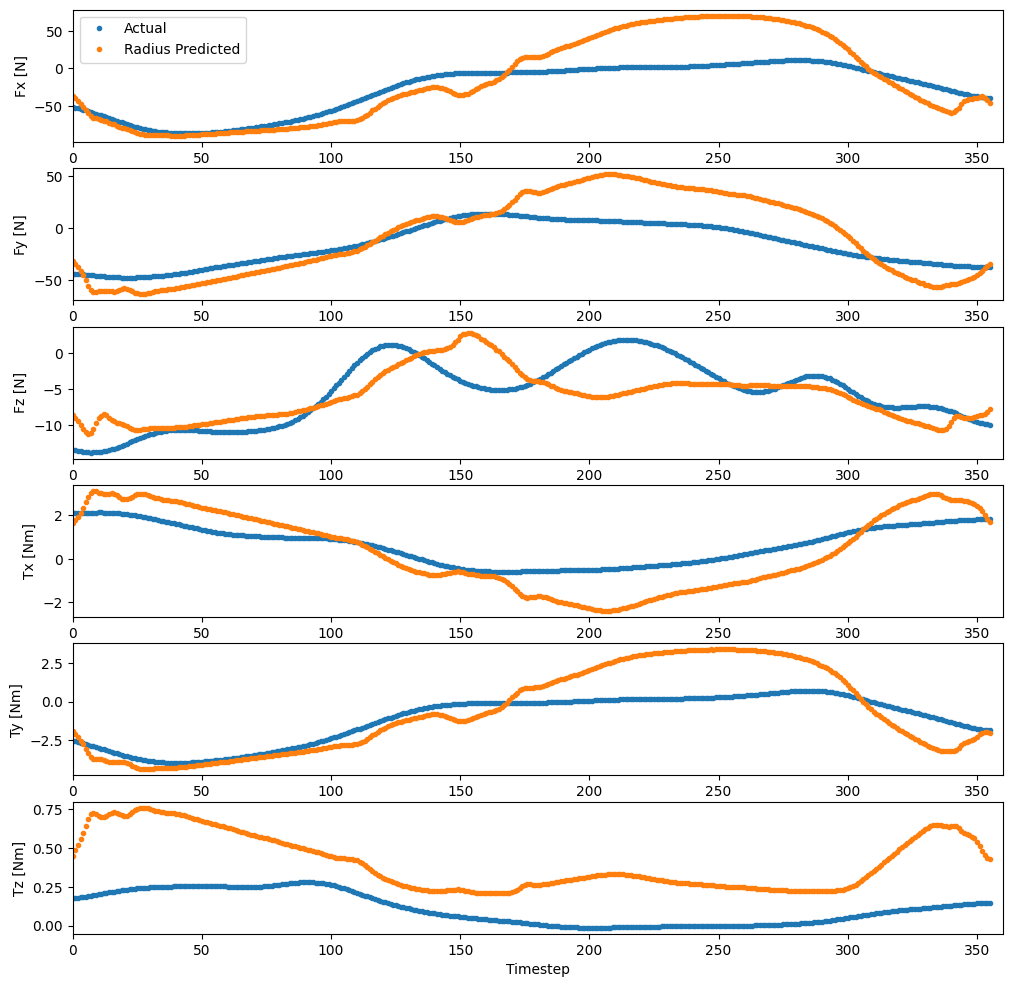

In [10]:
# Plot to visualize ground truth of one cycle with predictions overlaid - quick interpretation of model accuracy
cycle = 9

plt.figure(figsize=(12,12))
plt.subplot(611)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,0],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,0],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,0],'.')
plt.xlabel('Timestep')
plt.ylabel('Fx [N]')
plt.legend(['Actual','Radius Predicted'])
plt.xlim([0,360])
plt.subplot(612)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,1],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,1],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,1],'.')
plt.xlabel('Timestep')
plt.ylabel('Fy [N]')
plt.xlim([0,360])
plt.subplot(613)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,2],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,2],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,2],'.')
plt.xlabel('Timestep')
plt.ylabel('Fz [N]')
plt.xlim([0,360])
plt.subplot(614)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,3],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,3],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,3],'.')``
plt.xlabel('Timestep')
plt.ylabel('Tx [Nm]')
plt.xlim([0,360])
plt.subplot(615)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,4],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,4],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,4],'.')
plt.xlabel('Timestep')
plt.ylabel('Ty [Nm]')
plt.xlim([0,360])
plt.subplot(616)
plt.plot(np.arange(real_y.shape[1]),real_y[cycle,:,5],'.')
plt.plot(np.arange(real_y.shape[1]),radius_predictions[0,:,5],'.')
#plt.plot(np.arange(testset_y.shape[1]),resnet_predictions[0,:,5],'.')
plt.xlabel('Timestep')
plt.ylabel('Tz [Nm]')
plt.xlim([0,360])
plt.savefig('Example_Result_ModifiedNormalization.png')

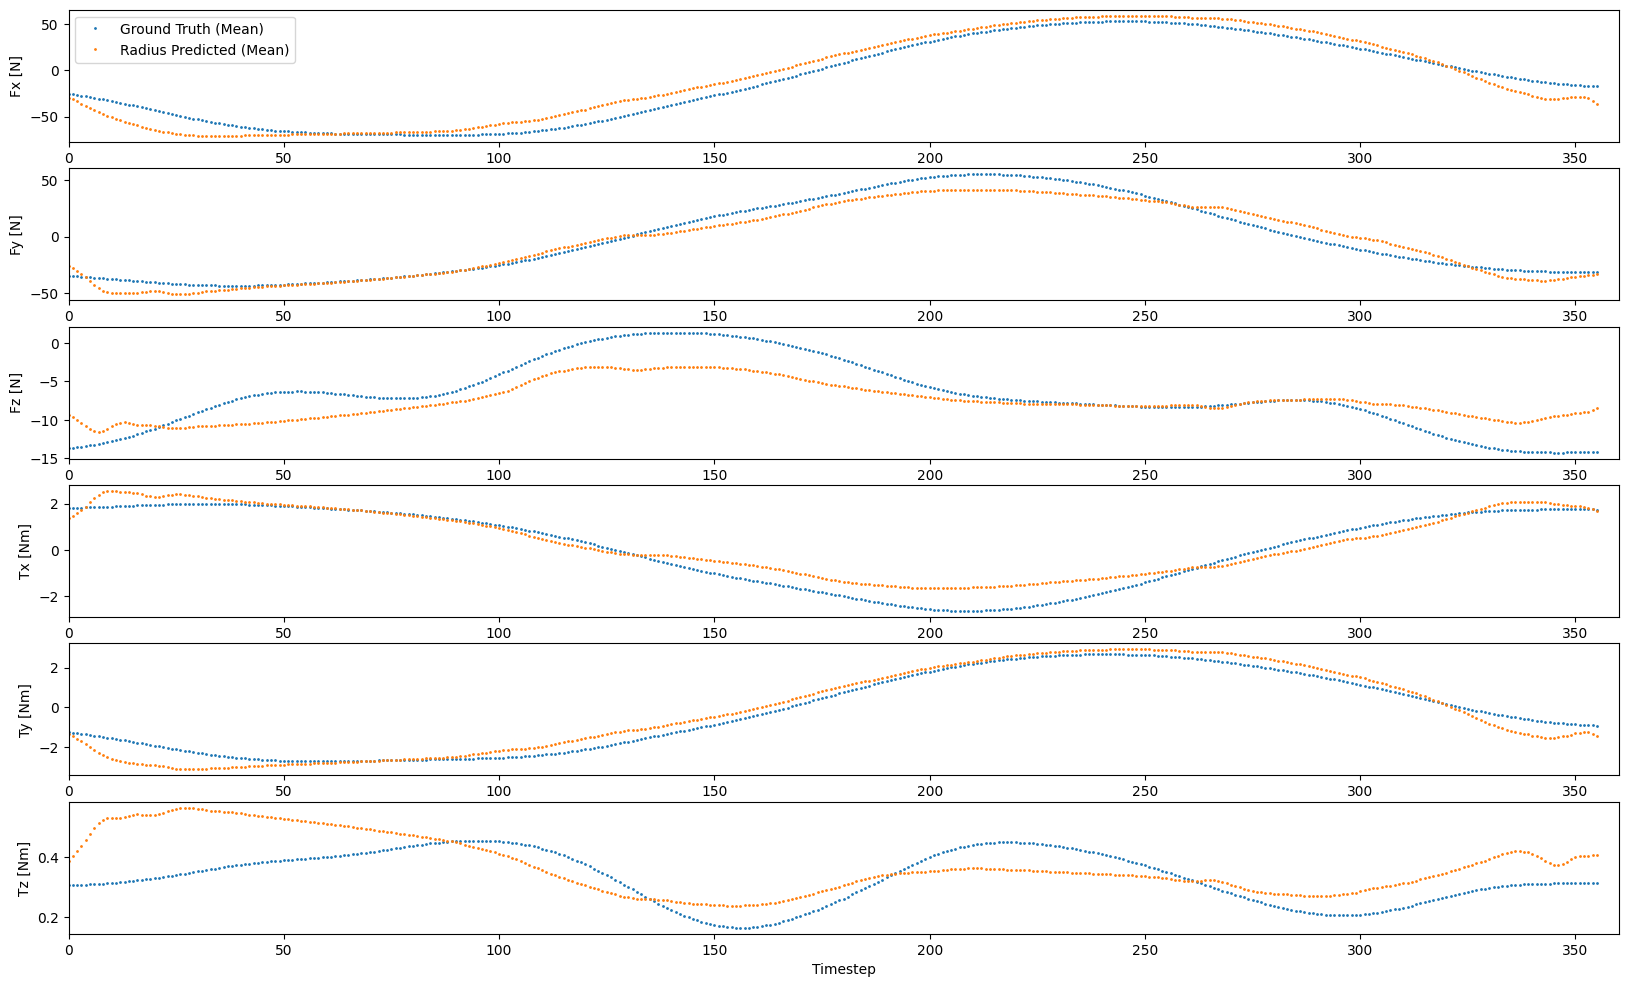

In [11]:
mean_real_y = np.mean(real_y, axis=0)
mean_radius_predictions = np.mean(radius_predictions, axis=0)

plt.figure(figsize=(20,12))

plt.subplot(611)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,0], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,0], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,0] - std_y[0], mean_real_y[:,0] + std_y[0], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,0] - std_y[0], mean_radius_predictions[:,0] + std_y[0], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Fx [N]')
plt.legend(['Ground Truth (Mean)', 'Radius Predicted (Mean)'])
plt.xlim([0,360])

plt.subplot(612)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,1], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,1], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,1] - std_y[1], mean_real_y[:,1] + std_y[1], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,1] - std_y[1], mean_radius_predictions[:,1] + std_y[1], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Fy [N]')
plt.xlim([0,360])

plt.subplot(613)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,2], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,2], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,2] - std_y[2], mean_real_y[:,2] + std_y[2], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,2] - std_y[2], mean_radius_predictions[:,2] + std_y[2], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Fz [N]')
plt.xlim([0,360])

plt.subplot(614)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,3], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,3], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,3] - std_y[3], mean_real_y[:,3] + std_y[3], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,3] - std_y[3], mean_radius_predictions[:,3] + std_y[3], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Tx [Nm]')
plt.xlim([0,360])

plt.subplot(615)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,4], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,4], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,4] - std_y[4], mean_real_y[:,4] + std_y[4], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,4] - std_y[4], mean_radius_predictions[:,4] + std_y[4], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Ty [Nm]')
plt.xlim([0,360])

plt.subplot(616)
plt.plot(np.arange(test_y.shape[1]), mean_real_y[:,5], '.', markersize=2)
plt.plot(np.arange(test_y.shape[1]), mean_radius_predictions[:,5], '.', markersize=2)
#plt.fill_between(np.arange(test_y.shape[1]), mean_real_y[:,5] - std_y[5], mean_real_y[:,5] + std_y[5], alpha=0.3)
#plt.fill_between(np.arange(test_y.shape[1]), mean_radius_predictions[:,5] - std_y[5], mean_radius_predictions[:,5] + std_y[5], alpha=0.3)
plt.xlabel('Timestep')
plt.ylabel('Tz [Nm]')
plt.xlim([0,360])

plt.savefig('Example_Result_ModifiedNormalization.png')

Median MDPE for Fx: -5.62597734382217
Mean MDPE for Fx: -6.557422007359786
Standard Deviation of MDPE for Fx: 12.120782070703891
Median MDPE for Fy: -8.910662348790314
Mean MDPE for Fy: -6.6986995286443864
Standard Deviation of MDPE for Fy: 11.650118594154888
Median MDPE for Fz: -28.4328115612824
Mean MDPE for Fz: -31.379748525636085
Standard Deviation of MDPE for Fz: 24.33839900010198
Median MDPE for Tx: 7.147077293872088
Mean MDPE for Tx: 7.257560143349128
Standard Deviation of MDPE for Tx: 13.289971634419855
Median MDPE for Ty: -5.475545582091794
Mean MDPE for Ty: -4.710306648063577
Standard Deviation of MDPE for Ty: 13.918851785474597
Median MDPE for Tz: 34.05626862979062
Mean MDPE for Tz: 64.7417103645299
Standard Deviation of MDPE for Tz: 60.72519087142065
18


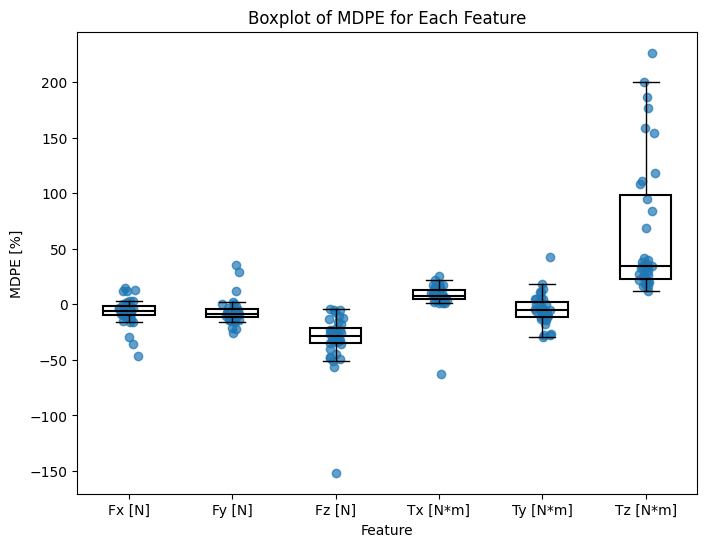

In [12]:
mdpe = np.empty([radius_predictions.shape[0],6])
md_column = np.empty(6)
std_column = np.empty(6)
mean_column = np.empty(6)
for i in range(6):
    for j in range(radius_predictions.shape[0]):
        mdpe[j,i] = np.median(np.abs(real_y[j,:,i]-radius_predictions[j,:,i])/real_y[j,:,i])*100
    md_column[i] = np.median(mdpe[:,i])
    std_column[i] = np.std(mdpe[:,i])
    mean_column[i] = np.mean(mdpe[:,i])
    print(f"Median MDPE for {data.columns[i+9]}: {md_column[i]}")
    print(f"Mean MDPE for {data.columns[i+9]}: {mean_column[i]}")
    print(f"Standard Deviation of MDPE for {data.columns[i+9]}: {std_column[i]}")
mean_mdpe = np.mean(mdpe, axis=1)
lowest_mean_slice = np.argmax(mean_mdpe)
print(lowest_mean_slice)

# Create a list of feature names
feature_names = ['Fx [N]', 'Fy [N]', 'Fz [N]', 'Tx [N*m]', 'Ty [N*m]', 'Tz [N*m]']

# Create a scatter plot for each feature
for i in range(1, len(mdpe[0]) + 1):
    y = mdpe[:, i-1]
    x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-axis
    plt.scatter(x, y, alpha=0.7, color='tab:blue')

# Create a boxplot for each feature without color
bp = plt.boxplot(mdpe, labels=feature_names, patch_artist=True, 
                 positions=range(1, len(mdpe[0]) + 1), showfliers=False,
                 boxprops=dict(facecolor='none', edgecolor='black', linewidth=1.5),
                 medianprops=dict(color='black', linewidth=1.5))

# Set the title and labels
plt.title('Boxplot of MDPE for Each Feature')
plt.xlabel('Feature')
plt.ylabel('MDPE [%]')

# Show the plot
plt.show()

In [13]:
# real_out = stacked[-12460:][['SeriesID','Fx','Fy','Fz','Tx','Ty','Tz']]
# real_out.to_csv('G:/Studies/68FieldBasedWheelchair/Processed Data/Wheelchair Kinetics IMU/Machine Learning/Handcycle Segment Comparison Modified Normalization/Ground_Truth_Out.csv')

for i in range(len(testset_X[:,0,0])-1):
    lstm_test_performance[str(i)] = lstm_model.evaluate(x=testset_X[i:i+1,:,:],y=testset_y[i:i+1,:,:])
    resnet_test_performance[str(i)] = resnet_model.evaluate(x=testset_X[i:i+1,:,:],y=testset_y[i:i+1,:,:])
               
for i in range(len(valset_X[:,0,0])-1):
    lstm_val_performance[str(i)] = lstm_model.evaluate(x=valset_X[i:i+1,:,:],y=valset_y[i:i+1,:,:])
    resnet_val_performance[str(i)] = resnet_model.evaluate(x=valset_X[i:i+1,:,:],y=valset_y[i:i+1,:,:])

import csv
with open('lstm_test_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, lstm_test_performance.keys())
    w.writeheader()
    w.writerows(lstm_test_performance)
    
with open('lstm_val_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, lstm_val_performance.keys())
    w.writeheader()
    w.writerow(lstm_val_performance)
    
with open('resnet_test_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, resnet_test_performance.keys())
    w.writeheader()
    w.writerow(resnet_test_performance)
    
with open('resnet_val_performance.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, resnet_val_performance.keys())
    w.writeheader()
    w.writerow(resnet_val_performance)

import csv
# open file for writing, "w" is writing
w = csv.writer(open("Segment_Comparison_Test_Performance.csv", "w"))

# loop over dictionary keys and values
for key, val in test_performance.items():

    # write every key and value to file
    w.writerow([key, val])